# Spam detection
The main aim of this project is to build a machine learning classifier that is able to automatically detect 
spammy articles, based on their content. 

In [1]:
! sh bootstrap.sh

    100% |████████████████████████████████| 18.7MB 83kB/s 
    100% |████████████████████████████████| 14.7MB 128kB/s 
    100% |████████████████████████████████| 194kB 1.9MB/s 
    100% |████████████████████████████████| 61kB 4.3MB/s 
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.cross_validation import KFold
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

In [7]:
#Load train dataset
df = pd.read_csv("enwiki.draft_quality.201608-201701.feature_labels.tsv", sep="\t")
#shuffle the dataframe so that samples will be randomly distributed in Cross Validation Folds
df = shuffle(df)
#Replace strings with integers : 1 for OK and 0 for Not OK
df["draft_quality"] = df["draft_quality"].replace({"OK" : 1, "vandalism" : 0, "spam" : 0, "attack" : 0})
#═df["Markup_chars_thresholded"]=(df['feature.(wikitext.revision.markup_chars / max(wikitext.revision.chars, 1))']>0.35)*1
#Put features and labels on differents dataframes
X=df.drop(["draft_quality"], 1)
Y=df["draft_quality"]

df2 = pd.read_csv("enwiki.draft_quality.50k_stratified.feature_labels.tsv", sep="\t")
df2["draft_quality"] = df2["draft_quality"].replace({"OK" : 1, "vandalism" : 0, "spam" : 0, "attack" : 0})
#df2["Markup_chars_thresholded"]=(df2['feature.(wikitext.revision.markup_chars / max(wikitext.revision.chars, 1))']>0.35)*1
X2=df2.drop(["draft_quality"], 1)
Y2=df2["draft_quality"]
X2=np.array(X2)
Y2=np.array(Y2)
X=np.array(X)
Y=np.array(Y)

In [8]:
#lenghts of boths datasets
print(len(X))
print(len(X2))

324570
52518


# Modeling
We tried out various models and selected the best performing models (with the best performing parameter settings for each model). At the end, we retained 3 models which are:
1.	Naïve Bayes Gaussian
2.	Random forest
3.	Logistic regression

#### Naïve Bayes Gaussian

In [10]:
weights=np.array([0.7,1-0.7])
clf = BernoulliNB(alpha=22, class_prior=weights)
clf.fit(X2, Y2)
prediction_nb=clf.predict(X)
confusion=confusion_matrix(Y, prediction_nb, labels=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[  8723   1630]
 [ 22449 291768]]
Over all the not-OK articles included in the dataset, we detect:
0.84255771274
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.279834466829


#### logistic regression

In [12]:
clf2 = LogisticRegression(penalty='l1', random_state=0, class_weight={1:0.1, 0: 0.9})
clf2.fit(X2, Y2)
prediction_lr=clf2.predict(X)
confusion=confusion_matrix(Y, prediction_lr, labels=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[ 10131    222]
 [103294 210923]]
Over all the not-OK articles included in the dataset, we detect:
0.978556940017
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.0893189332158


#### random forest

In [6]:
clf3 = RandomForestClassifier(n_estimators=2, min_samples_leaf=1, random_state=25, class_weight={1:0.9, 0: 0.1})
clf3.fit(X2, Y2)
prediction_rf=clf3.predict(X)
confusion=confusion_matrix(Y, prediction_rf, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[18530  7731]
 [  816 25441]]
Over all the not-OK articles included in the dataset, we detect:
0.705609078101
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.957820738137


## Combination 1
We decided to try combining these models in order to construct a better and more consistent one.

### voting system

In [7]:
#Here we construct our voting function
def voting(pred1, pred2, pred3):
    final_prediction=np.zeros_like(pred1)
    for i in range(len(pred1)):
        if pred1[i]==pred2[i]:
            final_prediction[i]=pred1[i]
        elif pred1[i]==pred3[i]:
            final_prediction[i]=pred1[i]
        elif pred2[i]==pred3[i]:
            final_prediction[i]=pred2[i]
    return final_prediction

In [8]:
#Here we make the prediction using voting function (with the three models defined above)
prediction= voting(prediction_lr, prediction_nb, prediction_rf)
from sklearn.metrics import confusion_matrix
confusion=confusion_matrix(Y, prediction, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[23013  3248]
 [ 1077 25180]]
Over all the not-OK articles included in the dataset, we detect:
0.876318495107
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.955292652553


### customizing

In [9]:
#Since we are inerested in negatives (not-OK) we will analyze how many times a model detects a not-OK article while
#the others don't
def get_missclasified_indexes(pred1, Y_true, Class):
    index_list=[]
    a=0
    b=1
    if Class=="negative":
        a=1
        b=0  
    for i in range(len(pred1)):
        if pred1[i]==a and Y_true[i]==b:
            index_list.append(i)
    return index_list

In [10]:
false_negative_indexes=get_missclasified_indexes(prediction, Y, "negative")
print(len(prediction[false_negative_indexes]))
print(np.sum(prediction_nb[false_negative_indexes]!=prediction[false_negative_indexes]))
print(np.sum(prediction_rf[false_negative_indexes]!=prediction[false_negative_indexes]))
print(np.sum(prediction_lr[false_negative_indexes]!=prediction[false_negative_indexes]))

3248
1128
245
551


In [11]:
##Here we define our function based on the results above
def voting_customized(pred1, pred2, pred3):
    final_prediction=np.zeros_like(pred1)
    for i in range(len(pred1)):
        if pred1[i]==0:
            final_prediction[i]=0
        else:
            final_prediction[i]=pred3[i]
    return final_prediction

In [12]:
#making a prediction with our new function
prediction= voting_customized(prediction_lr, prediction_nb, prediction_rf)
confusion=confusion_matrix(Y, prediction, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[23809  2452]
 [ 1385 24872]]
Over all the not-OK articles included in the dataset, we detect:
0.906629602833
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.945026593633


In [13]:
false_negative_indexes=get_missclasified_indexes(prediction, Y, "negative")
print(len(prediction[false_negative_indexes]))
print(np.sum(prediction_nb[false_negative_indexes]!=prediction[false_negative_indexes]))
print(np.sum(prediction_rf[false_negative_indexes]!=prediction[false_negative_indexes]))
print(np.sum(prediction_lr[false_negative_indexes]!=prediction[false_negative_indexes]))

2452
1128
0
0


Here you can see that benefited from the good behavior of the logistic regression and the random forest. By contrast,
we couldn't do the same with the naive bayse, because, this makes as missclassify a lot of OK articles, which leads to
a low precision.

In [13]:
from sklearn.metricsicsicsics import roc_curve,auc 

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score),
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1] color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.

## Combination 2
Now, we would like the capture more of the not-OK articles. To this end, we decided to include a few false positives 
in the training datasets. In order so in an intelligent way and to select some representative samples, we first 
analyzed these false positives. 

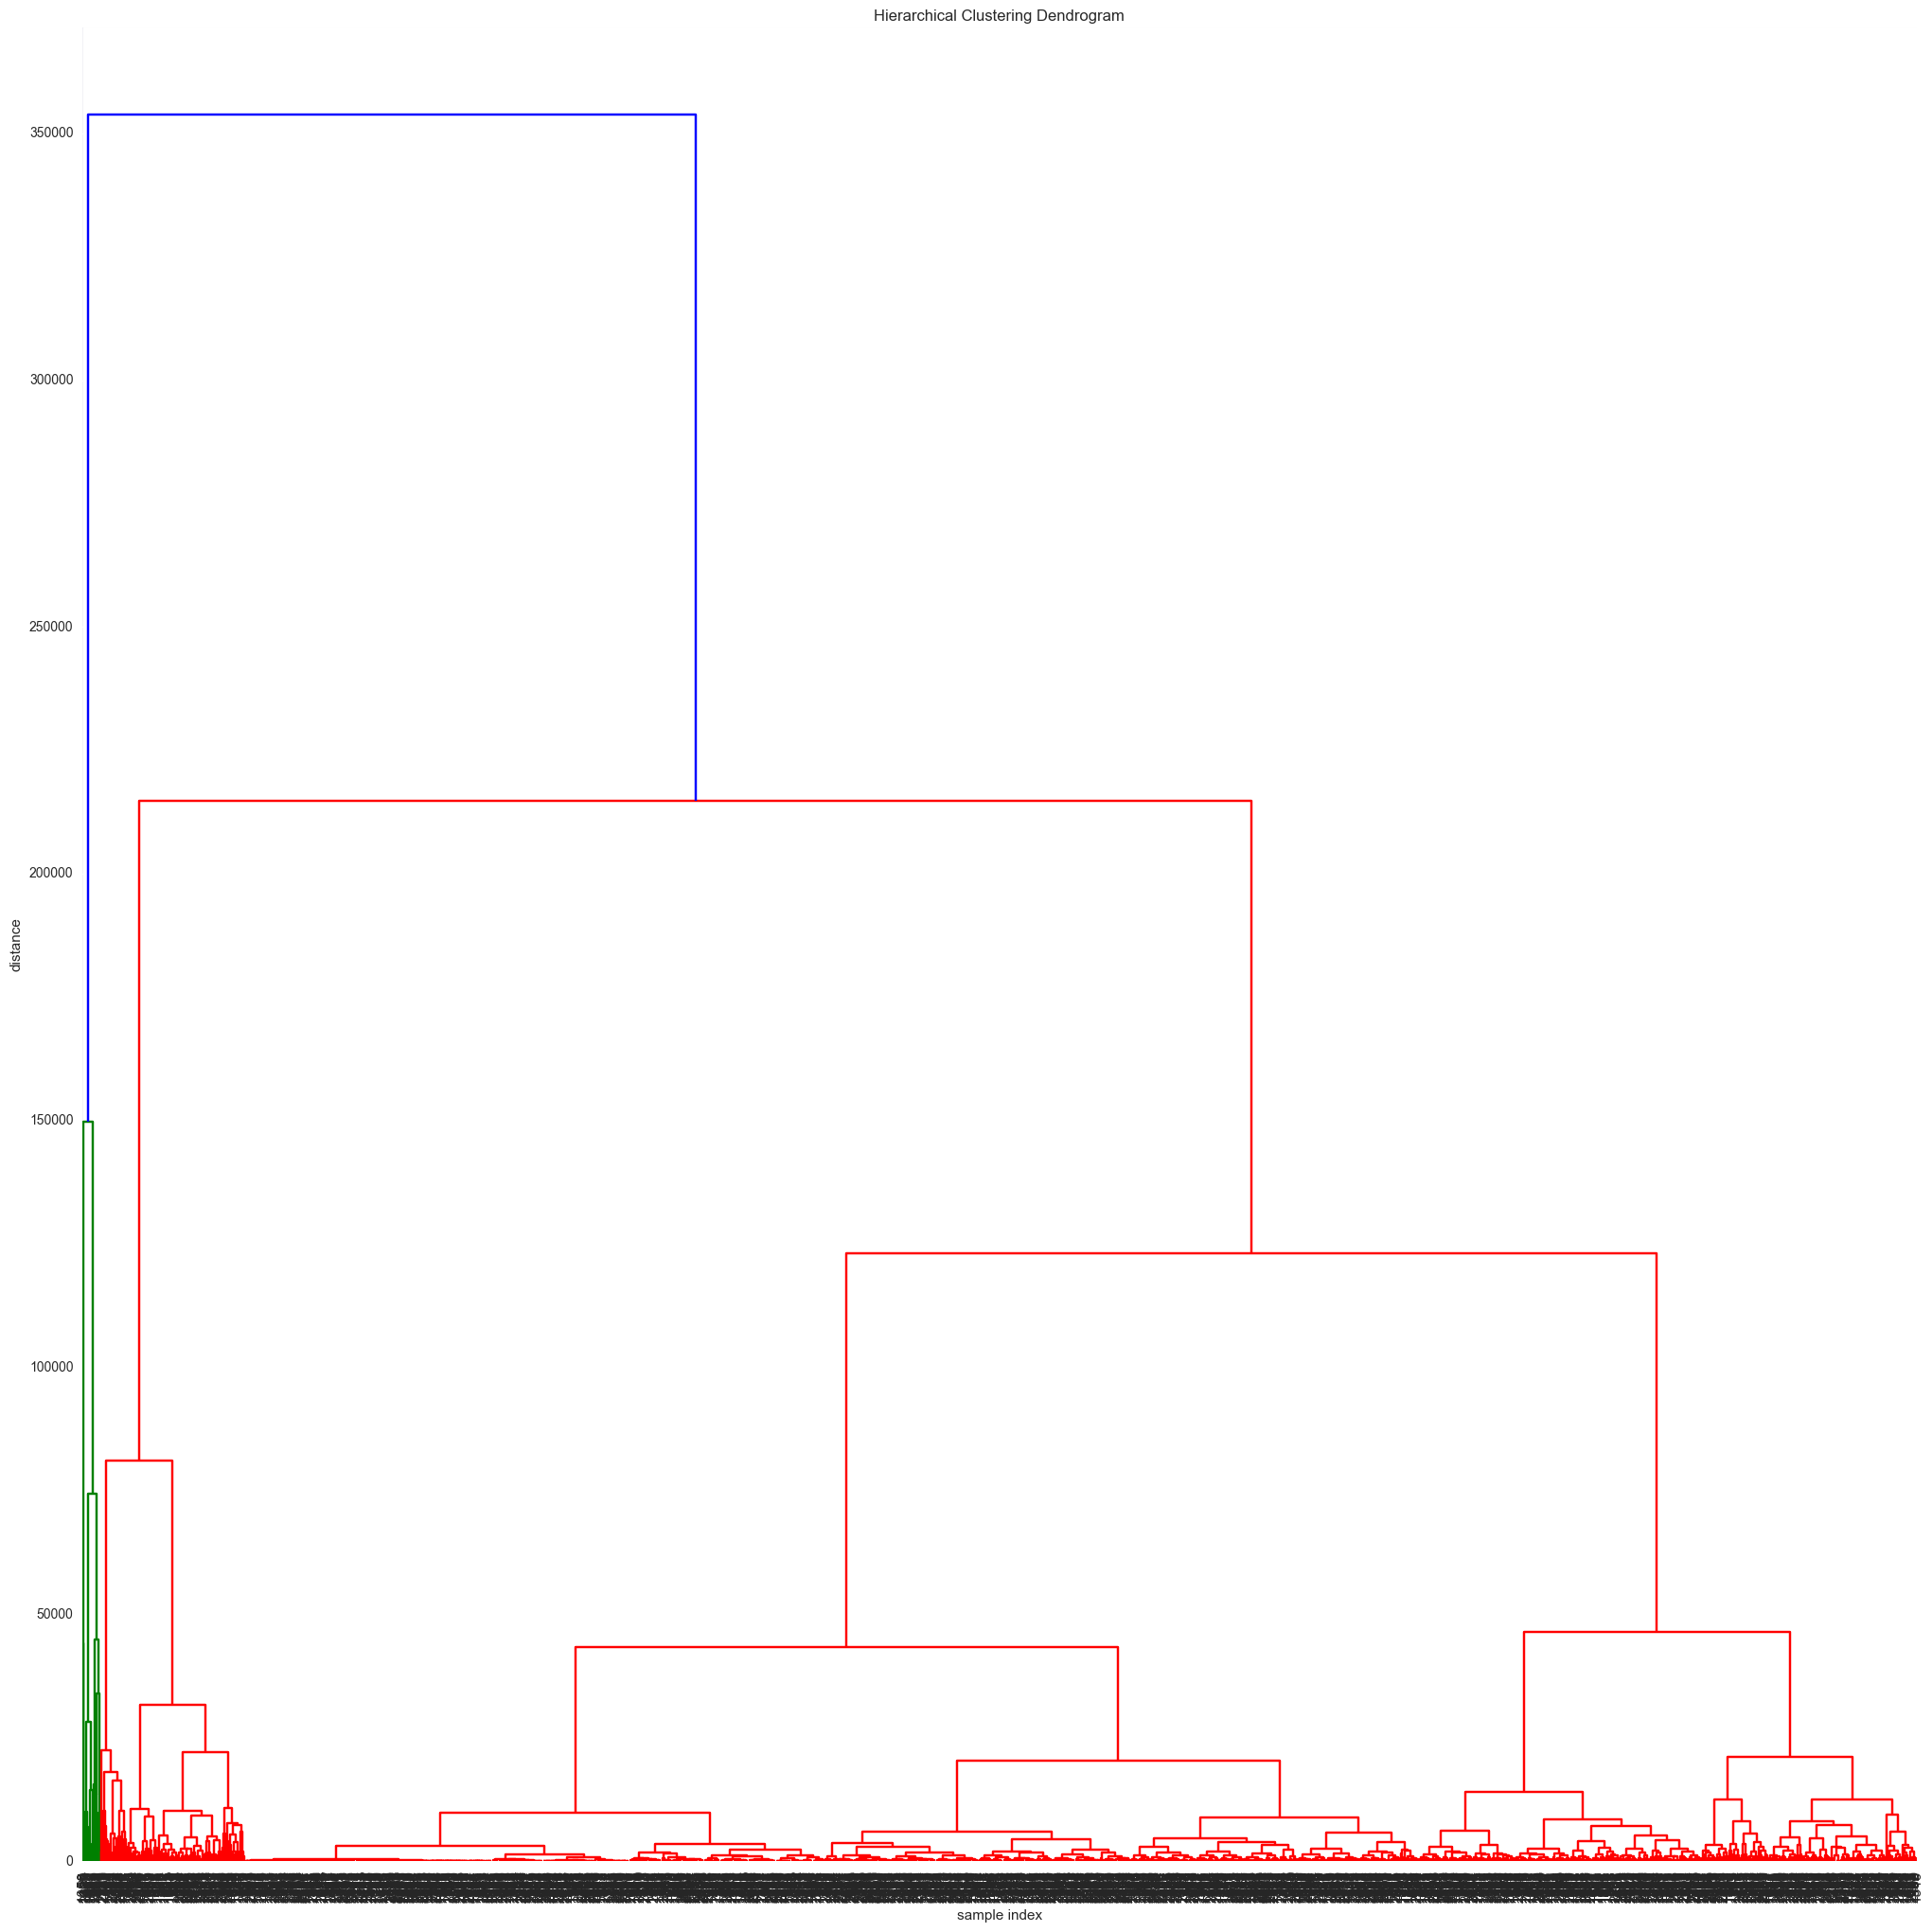

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X[false_negative_indexes], 'ward')
plt.figure(figsize=(25, 25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90., 
    leaf_font_size=11.,  
)
plt.show()

This means that we have two big clusters of false positives (green and red). We have chosen to pick up 
randomly 50 samples of each cluster. 

In [18]:
#we perform a kmeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(X[false_negative_indexes])
cluster_labels=kmeans.labels_
print(cluster_labels)
print(np.unique(cluster_labels))

[0 0 0 ..., 0 0 0]
[0 1]


In [23]:
#Picking up the sapmles from theclusters and adding them to the training dataset.

false_negatives_cluster0=[]
false_negatives_cluster1=[]

for i in range(1,11):
    random.seed(a=i)
    false_negatives_cluster0.append(random.choice([w for index_w, w in enumerate(false_negative_indexes) if cluster_labels[index_w] == 0]))
for i in range(1,11):
    random.seed(a=i)
    false_negatives_cluster1.append(random.choice([w for index_w, w in enumerate(false_negative_indexes) if cluster_labels[index_w] == 1]))


#adding 1st cluster's samples
Y2=np.reshape(np.dstack(Y2), (len(Y2),1))
temp_arr=np.array([Y[false_negatives_cluster0]])
temp_arr=np.reshape(np.dstack(temp_arr), (10,1))

X2_new = np.vstack((X2, X[false_negatives_cluster0]))
Y2_new=np.vstack((Y2, temp_arr))
# Second
temp_arr2=np.array([Y[false_negatives_cluster1]])
temp_arr2=np.reshape(np.dstack(temp_arr2), (10,1))

X2_new = np.vstack((X2_new, X[false_negatives_cluster1]))
Y2_new=np.vstack((Y2_new, temp_arr2))


### Now we do the prediction again

#### random forest

In [24]:
Y2_new=np.reshape(np.dstack(Y2_new), (len(Y2_new),))

clf3.fit(X2_new, Y2_new)
prediction_rf_new=clf3.predict(X)
confusion=confusion_matrix(Y, prediction_rf_new, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)


[[18745  7516]
 [  812 25445]]
Over all the not-OK articles included in the dataset, we detect:
0.713796123529
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.95848033952


#### logistic regression

In [25]:
clf2.fit(X2_new, Y2_new)
prediction_lr_new=clf2.predict(X)
confusion=confusion_matrix(Y, prediction_lr_new, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[22942  3319]
 [ 1097 25160]]
Over all the not-OK articles included in the dataset, we detect:
0.873614866151
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.954365822206


#### Naive Bayse

In [26]:
from sklearn.naive_bayes import BernoulliNB
weights=np.array([0.7,1-0.7])
clf = BernoulliNB(alpha=22, class_prior=weights)
clf.fit(X2_new, Y2_new)
prediction_nb_new=clf.predict(X)
confusion=confusion_matrix(Y, prediction_nb_new, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[23797  2464]
 [ 2685 23572]]
Over all the not-OK articles included in the dataset, we detect:
0.90617265146
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.89861037686


#### Voting

In [27]:
prediction= voting(prediction_lr_new, prediction_nb_new, prediction_rf_new)
confusion=confusion_matrix(Y, prediction, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[23035  3226]
 [ 1099 25158]]
Over all the not-OK articles included in the dataset, we detect:
0.87715623929
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.954462583907


#### Customizing

In [28]:
def voting_customized2(pred1, pred2, pred3):
    final_prediction=np.zeros_like(pred1)
    for i in range(len(pred1)):
        if pred1[i]==0:
            final_prediction[i]=0     
        else:
            final_prediction[i]=pred2[i]
    return final_prediction

In [29]:
prediction= voting_customized2(prediction_lr_new, prediction_nb_new, prediction_rf_new)
confusion=confusion_matrix(Y, prediction, labels=None, sample_weight=None)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[24695  1566]
 [ 2873 23384]]
Over all the not-OK articles included in the dataset, we detect:
0.940367845855
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.895784968079


In [16]:
#Load train dataset
df = pd.read_csv("./enwiki.draft_quality.50k_stratified.feature_labels.tsv", sep="\t")
#shuffle the dataframe so that samples will be randomly distributed in Cross Validation Folds
df = shuffle(df)
#Replace strings with integers : 1 for OK and 0 for Not OK
df["draft_quality"] = df["draft_quality"].replace({"OK" : 1, "vandalism" : 0, "spam" : 0, "attack" : 0})
#═df["Markup_chars_thresholded"]=(df['feature.(wikitext.revision.markup_chars / max(wikitext.revision.chars, 1))']>0.35)*1
#Put features and labels on differents dataframes
X=df.drop(["draft_quality"], 1)
Y=df["draft_quality"]

In [11]:
from sklearn.ensemble import AdaBoostClassifier

In [22]:
clf = AdaBoostClassifier(n_estimators=300)

In [23]:
clf.fit(X, Y)
prediction=clf.predict(X)
confusion=confusion_matrix(Y, prediction)
print(confusion)
recall=confusion[0,0]/(confusion[0,0]+confusion[0,1])
precision=confusion[0,0]/(confusion[0,0]+confusion[1,0])
print("Over all the not-OK articles included in the dataset, we detect:")
print(recall)
print("Over all the articles predicted as being not-OK, only this proportion is really not-OK:")
print(precision)

[[24890  1371]
 [ 1577 24680]]
Over all the not-OK articles included in the dataset, we detect:
0.947793305662
Over all the articles predicted as being not-OK, only this proportion is really not-OK:
0.940416367552


In [ ]:
2948

In [43]:
cpt = 0
for idx, item in enumerate (Y.values):
    if item != prediction[idx] and item == 0: # false positive ie SPAM uncatch 
        cpt +=  1
       #print (X.values[idx]
print (cpt)

1371
